<a href="https://colab.research.google.com/github/Tolulopeelijah/great_motors/blob/main/greatmotors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libaries

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.5 MB/s eta 0:00:00


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, power_transform
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,BaggingRegressor,VotingRegressor,StackingRegressor, HistGradientBoostingRegressor
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')
np.random.seed(20)

# loading the data

In [ ]:
training = pd.read_csv('Train.csv')
testing = pd.read_csv('Test.csv')
submission = pd.read_csv('SampleSubmission.csv')

In [ ]:
training.head(3)

,VehicleID,Location,Maker,Model,Year,Colour,Amount (Million Naira),Type,Distance
0,VHL12546,Abuja,Honda,Accord Coupe EX V-6,"2,011",Silver,2.2,Nigerian Used,NaN
1,VHL18827,Ibadan,Hyundai,Sonata,"2,012",Silver,3.5,Nigerian Used,"125,000"
2,VHL19499,Lagos,Lexus,RX 350,"2,010",Red,9.2,Foreign Used,"110,852"


In [ ]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VehicleID               7205 non-null   object 
 1   Location                7205 non-null   object 
 2   Maker                   7205 non-null   object 
 3   Model                   7205 non-null   object 
 4   Year                    7184 non-null   object 
 5   Colour                  7205 non-null   object 
 6   Amount (Million Naira)  7188 non-null   float64
 7   Type                    7008 non-null   object 
 8   Distance                4845 non-null   object 
dtypes: float64(1), object(8)
memory usage: 506.7+ KB


In [ ]:
training.isnull().sum()

VehicleID                    0
Location                     0
Maker                        0
Model                        0
Year                        21
Colour                       0
Amount (Million Naira)      17
Type                       197
Distance                  2360
dtype: int64

# cleaning the data

In [ ]:
def removeComa(d):
    d = d.replace(',', '')
    d = d.replace('.', '')
    return d

def clean(data):
    data.Year = data.Year.apply(str).apply(removeComa)
    data.Distance = data.Distance.apply(str).apply(removeComa)
    data['Year'][data['Year'] == 'nan'] = data['Year'][data['Year'] != 'nan'].astype('int64').mean()
    data.Year = data.Year.astype('int64')
    data.Type.fillna(data.Type.mode()[0], inplace = True)
    data = data.drop('VehicleID', axis = 1)
    data[data.Type == 'Brand New'].Distance.fillna(0, inplace = True)
    return data
training = clean(training)
testing = clean(testing)


In [ ]:
training['Amount (Million Naira)'].fillna(training['Amount (Million Naira)'].median(), inplace = True)

In [ ]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
edf = pd.DataFrame(encoder.fit_transform(training[['Location', 'Type']]).toarray())
edf.columns = ['Abuja', 'Ibadan', 'Lagos', 'Nigerian Used', 'Foreign Used', 'Brand New']
training = training.join(edf)
training = training.drop(['Location', 'Type'], axis = 1)

edf = pd.DataFrame(encoder.transform(testing[['Location', 'Type']]).toarray())
edf.columns = ['Abuja', 'Ibadan', 'Lagos', 'Nigerian Used', 'Foreign Used', 'Brand New']
testing = testing.join(edf)
testing = testing.drop(['Location', 'Type'], axis = 1)

In [ ]:
training

,Maker,Model,Year,Colour,Amount (Million Naira),Distance,Abuja,Ibadan,Lagos,Nigerian Used,Foreign Used,Brand New
0,Honda,Accord Coupe EX V-6,2011,Silver,2.20,nan,1.0,0.0,0.0,0.0,0.0,1.0
1,Hyundai,Sonata,2012,Silver,3.50,125000,0.0,1.0,0.0,0.0,0.0,1.0
2,Lexus,RX 350,2010,Red,9.20,110852,0.0,0.0,1.0,0.0,1.0,0.0
3,Mercedes-Benz,GLE-Class,2017,Blue,22.80,30000,1.0,0.0,0.0,0.0,1.0,0.0
4,Toyota,Highlander,2002,Red,2.60,125206,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7200,Honda,Civic,2018,Gray,5.70,65000,1.0,0.0,0.0,0.0,1.0,0.0
7201,BMW,X3,2007,White,4.00,200000,1.0,0.0,0.0,0.0,0.0,1.0
7202,Toyota,RAV4 2.5 Limited 4x4,2010,Black,2.85,nan,1.0,0.0,0.0,0.0,0.0,1.0
7203,Mercedes-Benz,GLK-Class 350,2012,Black,8.65,85750,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:

le = LabelEncoder()
training['Model'] = le.fit_transform(training['Model'])
training['Colour'] = le.fit_transform(training['Colour'])
training['Maker'] = le.fit_transform(training['Maker'])


testing['Model'] = le.fit_transform(testing['Model'])
testing['Colour'] = le.fit_transform(testing['Colour'])
testing['Maker'] = le.fit_transform(testing['Maker'])

training['Year'] = training['Year'].astype('int64')
testing['Year'] = testing['Year'].astype('int64')



In [ ]:
training

,Maker,Model,Year,Colour,Amount (Million Naira),Distance,Abuja,Ibadan,Lagos,Nigerian Used,Foreign Used,Brand New
0,17,117,2011,16,2.20,nan,1.0,0.0,0.0,0.0,0.0,1.0
1,19,1049,2012,16,3.50,125000,0.0,1.0,0.0,0.0,0.0,1.0
2,29,908,2010,15,9.20,110852,0.0,0.0,1.0,0.0,1.0,0.0
3,34,508,2017,2,22.80,30000,1.0,0.0,0.0,0.0,1.0,0.0
4,52,569,2002,15,2.60,125206,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7200,17,320,2018,7,5.70,65000,1.0,0.0,0.0,0.0,1.0,0.0
7201,3,1172,2007,19,4.00,200000,1.0,0.0,0.0,0.0,0.0,1.0
7202,52,860,2010,1,2.85,nan,1.0,0.0,0.0,0.0,0.0,1.0
7203,34,512,2012,1,8.65,85750,0.0,0.0,1.0,0.0,1.0,0.0


In [18]:

ss = StandardScaler()
training.Model = ss.fit_transform(training[['Model']])
training.Maker = ss.fit_transform(training[['Maker']])
training['Year'] = training['Year'] / training['Year'].max()
# training.Distance = power_transform(training[["Distance"]])

testing.Model = ss.fit_transform(testing[['Model']])
testing.Maker = ss.fit_transform(testing[['Maker']])
testing['Year'] = testing['Year'] / testing['Year'].max()
# testing.Distance = power_transform(testing[["Distance"]])


In [19]:
training.drop(['Maker', 'Foreign Used', 'Colour', 'Lagos'], axis = 1)
testing.drop(['Maker', 'Foreign Used', 'Colour', 'Lagos'], axis = 1)

,Model,Year,Distance,Abuja,Ibadan,Nigerian Used,Brand New
0,-1.692645,0.993076,305240,1.0,0.0,0.0,0.0
1,-0.944022,0.995549,nan,0.0,0.0,0.0,0.0
2,0.025932,0.991592,nan,0.0,0.0,0.0,0.0
3,-0.944022,0.994560,1668390,0.0,0.0,0.0,0.0
4,-0.494849,0.995549,888620,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2056,-1.263001,0.999011,26500,1.0,0.0,0.0,0.0
2057,0.800593,0.994560,990000,0.0,1.0,0.0,0.0
2058,-0.944022,0.996538,1080000,0.0,1.0,0.0,0.0
2059,0.221224,0.995549,524850,1.0,0.0,0.0,0.0


In [20]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7205 entries, 0 to 7204
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Maker                   7205 non-null   float64
 1   Model                   7205 non-null   float64
 2   Year                    7205 non-null   float64
 3   Colour                  7205 non-null   int64  
 4   Amount (Million Naira)  7205 non-null   float64
 5   Distance                7205 non-null   object 
 6   Abuja                   7205 non-null   float64
 7   Ibadan                  7205 non-null   float64
 8   Lagos                   7205 non-null   float64
 9   Nigerian Used           7205 non-null   float64
 10  Foreign Used            7205 non-null   float64
 11  Brand New               7205 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 675.6+ KB


In [34]:
X_d = training[training.Distance != 'nan']
y_d = X_d.pop('Distance')

y_d = y_d.astype('int')
xg = xgboost.XGBRegressor()
train, test, yrain, yest = train_test_split(X_d, y_d)
xg.fit(train, yrain)
p = xg.predict(test)

[22:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
indices = training[training['Distance'] == 'nan'].index.tolist()
for i, j in zip(indices, p):
    training.loc[i, 'Distance'] = j
    
training.Distance = training.Distance.apply(float)
testing.Distance = testing.Distance.apply(float)

In [37]:
training.Distance = power_transform(training[['Distance']])

In [38]:
X = training.drop(['Amount (Million Naira)'], axis = 1)
y = training['Amount (Million Naira)']

In [40]:
X.head(1)

,Maker,Model,Year,Colour,Distance,Abuja,Ibadan,Lagos,Nigerian Used,Foreign Used,Brand New
0,-1.376432,-1.445184,0.99456,16,0.204384,1.0,0.0,0.0,0.0,0.0,1.0


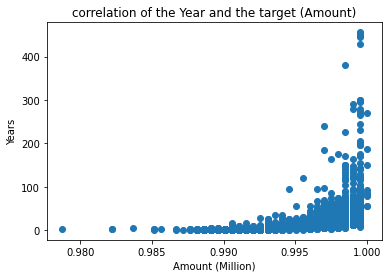

In [60]:
plt.scatter(X['Year'], y)
plt.title('correlation of the Year and the target (Amount)')
plt.xlabel('Amount (Million)')
plt.ylabel('Years')
plt.show()

In [ ]:
X.isnull().sum()

Maker               0
Model               0
Year                0
Colour              0
Distance         1148
Abuja               0
Ibadan              0
Lagos               0
Nigerian Used       0
Foreign Used        0
Brand New           0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
model1 = xgboost.XGBRegressor(random_state = 86)
model2 = RandomForestRegressor(random_state=20)
model3 = CatBoostRegressor(random_state = 86)
model4 = LinearRegression()
model5 = LGBMRegressor()
model6 = HistGradientBoostingRegressor()
model7 = ExtraTreesRegressor()

In [ ]:
kf = KFold(n_splits = 10, shuffle = True).split(X, y)
scores = []
for train, test in kf:
    model1.fit(X.loc[train], y.loc[train])
    scores.append(mean_squared_error(model1.predict(X.loc[test]), y.loc[test]))
print(np.mean(scores))

148.05058069522926


In [ ]:
X_train.isnull().sum()

Maker              0
Model              0
Year               0
Colour             0
Distance         860
Abuja              0
Ibadan             0
Lagos              0
Nigerian Used      0
Foreign Used       0
Brand New          0
dtype: int64

In [ ]:
mse = []
for i in [model1, model2, model3,model4, model5, model6, model7]:
    i.fit(X_train, y_train)
    pre = i.predict(X_test)
    mse.append(mean_squared_error(pre, y_test, squared = False))


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
print(mse)

In [ ]:
model = VotingRegressor([('model1', model1),('modelf', model2), ('model3', model3), ('model4', model4), ('model6', model6), ('model7', model7)],weights=(0.6,0.5,1,0.4, 0.5, 0.5))
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
np.mean(mean_squared_error(y_test,val_pred, squared = False))

In [ ]:
# modell = StackingRegressor(estimators = [('model1', model1),('modelf', model2), ('model3', model3), ('model4', model4), ('model5', model5), ('model6', model6), ('model7', model7)], final_estimator = model)
# modell.fit(X_train, y_train)
# val_pred = modell.predict(X_test)
# np.mean(mean_squared_error(y_test,val_pred, squared = False))

In [ ]:
testing.info()

In [ ]:
pre = model.predict(testing)

In [ ]:
submission['Amount (Million Naira)'] = pre

In [ ]:
submission.to_csv('greatmotorsubmission.csv', index = False)

# Visualization

In [ ]:
for i in training.columns:
    plt.plot(training['Amount (Million Naira)'], training[i], 'o')
    plt.title(i)
    plt.xlabel('Amount')
    plt.ylabel(i)
    plt.show()

In [ ]:
X = training.drop('Amount (Million Naira)', axis = 1)
X['Distancesq'] = training.Distance ** 2
X['Distancecb'] = training.Distance ** 3
X['Yearsq'] = training['Year'] ** 2
X['Yearcb'] = training['Year'] ** 3
testing['Distancesq'] = testing.Distance ** 2
testing['Distancecb'] = testing.Distance ** 3
testing['Yearsq'] = testing['Year'] ** 2
testing['Yearcb'] = testing['Year'] ** 3
y = training['Amount (Million Naira)']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
mse = []
for i in [model1, model2, model3,model4, model5, model6, model7]:
    i.fit(X_train, y_train)
    pre = i.predict(X_test)
    mse.append(mean_squared_error(pre, y_test, squared = False))


In [ ]:
mse

In [ ]:
model = VotingRegressor([('model1', model1),('modelf', model3), ('model4', model4)],weights=(1,1,0.5))
model.fit(X_train, y_train)
val_pred = model.predict(X_test)
np.mean(mean_squared_error(y_test,val_pred, squared = False))

In [ ]:
pre = model3.predict(testing)

In [ ]:
submission['Amount (Million Naira)'] = pre

In [ ]:
submission.to_csv('greatmotorsubmission4.csv', index = False)